In [1]:
def Temperature(t,r,theta):
    import numpy as np
    
    #define the radial profile
    r0 = 2.0
    Tr = np.exp(-r/r0)
    
    #define the angular profile
    T0  = 2.0
    dT  = 0.1
    Tth = T0*(1+dT*np.cos(theta))
    
    return Tr*Tth

In [2]:
def grad_Temperature(t,r,theta):
    import numpy as np
    
    #define the radial profile
    r0     = 2.0
    Tr     = np.exp(-r/r0)
   
    #define the angular profile
    T0     = 2.0
    dT     = 0.1
    Tth    = T0*(1.0 + dT*np.cos(theta))
    
    #calculate the derivative of the radial profile and
    #the radial derivative of the temperature
    Tr_r   = -Tr/r0
    T_r    = Tr_r*Tth
    
    #calculate the derivatice of the angular profile and
    #the angular derivative of the temperature
    Tth_th = -T0*dT*np.sin(theta)
    T_th   = Tr*Tth_th/r
    
    return T_r, T_th

In [3]:
def PolarVel(state):
    #unpack the state
    x      = state[0]
    y      = state[1]
    vx     = state[2]
    vy     = state[3]
    
    #define the r unit vector
    v_cart = np.array([vx,vy])
    r_vec  = np.array([x,y])
    r_vec  = r_vec/np.sqrt(r_vec.dot(r_vec))
    
    #define the theta unit vector
    th_vec = np.array([-y,x])
    th_vec = th_vec/np.sqrt(th_vec.dot(th_vec))
    
    #project to get the polar components
    vr     = v_cart.dot(r_vec)
    vth    = v_cart.dot(th_vec)
    
    return vr, vth

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#evaluate the temperature field at a given resolution
nr  = 40
nth = 40 
r, theta = np.mgrid[0:2:nr*1j,0:2*np.pi:nth*1j]
T_field = Temperature(0,r,theta)

In [9]:
#define the ephemeris of the particle
time   = np.linspace(0,10,100)
R      =  0.7
a      =  0.13
#a      = 0
w      =  2.0*np.pi/10.0
x_t    =  (R+a*time)*np.cos(w*time)
y_t    =  (R+a*time)*np.sin(w*time)
vx_t   =  a*np.cos(w*time) - (R+a*time)*w*np.sin(w*time) 
vy_t   =  a*np.sin(w*time) + (R+a*time)*w*np.cos(w*time) 

In [10]:
#make the element's local measurement of temperature
r_t       = []
th_t      = []
Temp_meas = []
for instant, XX, YY in zip(time,x_t,y_t):
    RR = np.sqrt(XX**2 + YY**2)
    TH = np.arctan2(YY,XX)
    #pack the arrays
    r_t.append(RR)
    th_t.append(TH)
    Temp_meas.append(Temperature(instant,RR,TH))    
    
r_t       = np.array(r_t)
th_t      = np.array(th_t)
Temp_meas = np.array(Temp_meas)
    
#calculate the time derivative of Temperature
dTemp_meas = np.zeros(r_t.shape)
for i in range(1,len(r_t)-1):
    dTemp_meas[i] = (Temp_meas[i+1] - Temp_meas[i-1])/(time[i+1] - time[i-1])
dTemp_meas[0]  = np.NaN
dTemp_meas[-1] = np.NaN

In [11]:
#now try the material derivative

#first convert the velocity of the particle to polar
vr_t  = []
vth_t = [] 
for state in zip(x_t,y_t,vx_t,vy_t):
    vr, vth = PolarVel(state)
    vr_t.append(vr)
    vth_t.append(vth)
vr_t  = np.array(vr_t)
vth_t = np.array(vth_t) 
    
#second calculate the derivative of the temperature field at 
#the particle's position
d_Tempr  = []
d_Tempth = []
for instant,r_temp,th_temp in zip(time,r_t,th_t):
    T_r, T_th = grad_Temperature(instant,r_temp,th_temp)
    d_Tempr.append(T_r)
    d_Tempth.append(T_th)
d_Tempr  = np.array(d_Tempr)
d_Tempth = np.array(d_Tempth)
    
#finally calculate the total derivative
direction_deriv_T = d_Tempr*vr_t + d_Tempth*vth_t

C:\Users\Conrad\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


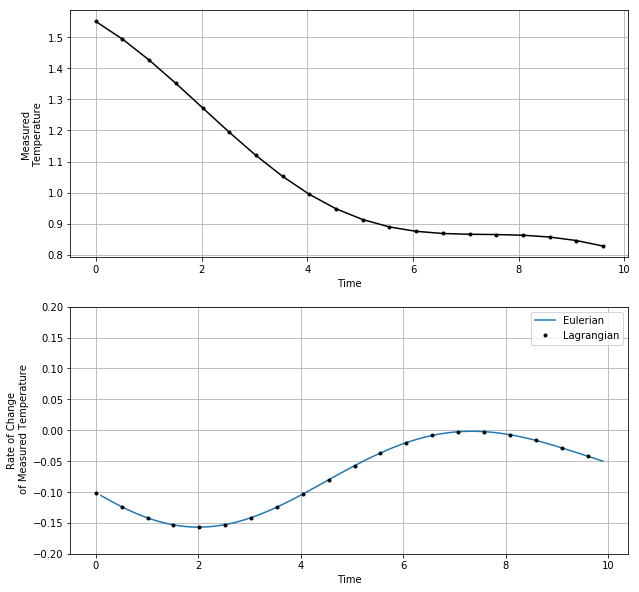

In [12]:
fig = plt.figure(figsize=(10,10))

ax2  = fig.add_subplot(2,1,1)
ax2.plot(time[::5],Temp_meas[::5],'k.-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Measured \nTemperature')
ax2.grid('on')

ax4 = fig.add_subplot(2,1,2)
ax4.plot(time,dTemp_meas,label='Eulerian')
ax4.plot(time[::5],direction_deriv_T[::5],'k.',label='Lagrangian')
ax4.set_xlabel('Time')
ax4.set_ylabel('Rate of Change\n of Measured Temperature')
ax4.set_ylim([-0.2,0.2])
ax4.grid(True)
ax4.legend()

plt.subplots_adjust(wspace=0.3)
#fig.savefig('c:/Users/Conrad/Documents/GitHub/BlogWyrm/Pictures/Blog Wyrm - Under The Hood/Material_Derivative_Scenario2_Temperature_plot.png',dpi=200)

Text(0.5,1.05,"Spiral Orbit Around a Static 'Hot' Earth\n")

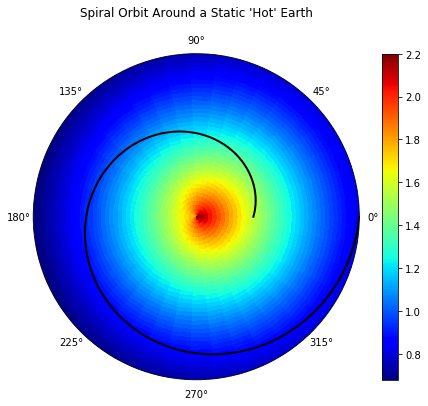

In [15]:
fig_prod1 = plt.figure(figsize=(8,6))
ax1_prod1 = fig_prod1.add_subplot(1,1,1,projection='polar')
pcmesh_data = ax1_prod1.pcolormesh(theta,r,T_field,cmap=cmap.jet)
ax1_prod1.plot(th_t,r_t,'k-',linewidth=2.0)
ax1_prod1.set_yticks([])
cbax = fig_prod1.colorbar(pcmesh_data)
ax1_prod1.set_title('Spiral Orbit Around a Static \'Hot\' Earth\n')
#fig_prod1.savefig('c:/users/Conrad/Documents/GitHub/BlogWyrm/Pictures/Blog Wyrm - Under The Hood/Material_Derivative_Scenario2_polarplot.png',dpi=200)